# Practice: Q-learning

_Reference:_ This notebook is based on Practical RL [week03](https://github.com/yandexdataschool/Practical_RL/tree/master/week03_model_free)

In [1]:
import os
import sys


if "google.colab" in sys.modules and not os.path.exists(".setup_complete"):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ["DISPLAY"] = ":1"

Starting virtual X frame buffer: Xvfb.


## Q-Learning Agent

This notebook will guide you through implementation of vanilla Q-learning algorithm. This part is based on the [Berkeley's RL course](https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html).

You need to implement the main methods of the agent, namely, action sampling and q-values update procedure.

In order to simplify the implementation, agent also has separate function to estimate the value function of the state given the q-function estimates. The value-function in this case can be estimated as the maximum of q-function values in current state:

$$
V(s) = \max_a Q(s, a)
$$

Once we can evaluate states, we can try to update our q-values accordingly, i.e. suppose we were in a state $s$ and took action $a$, which changed the state to $s'$ and yielded the reward $r$. In this case we can deduce that our q-function should be equal to:

$$
Q(s, a) = r + \gamma V(s')
$$

Here $\gamma$ is the discounting factor.

However, we don't want to change our q-value so radically on each step, because this would mean that we will be discarding all our previous updates to this value. Instead we will call this new value $Q'(s, a)$ and will update our q-function in a following maner:

$$
Q_{n+1}(s, a) = (1 - \alpha) \cdot Q_n(s, a) + \alpha \cdot Q_n'(s, a)
$$

Action sampling is done using the simple $\varepsilon$-greedy strategy, which means that we take random action with probability $\varepsilon$ or the best action (wrt the q-function values) otherwise.

In [2]:
import random
from collections import defaultdict


class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, n_actions):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.possible_actions = range(n_actions)
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))

    def get_qvalue(self, state, action):
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        self._qvalues[state][action] = value

    # -------------------------START OF YOUR CODE-------------------------#
    #                          !!!Important!!!                           #
    #              Please avoid using self._qvalues directly.            #
    #  There's a special self.get_qvalue/set_qvalue functions for that.  #
    # -------------------------START OF YOUR CODE-------------------------#

    def get_value(self, state):
        # Agent parameters.
        possible_actions = self.possible_actions

        # YOUR CODE HERE
        # Calculate the approximation of value function V(s).
        # value = ...

        value = max(self.get_qvalue(state, action) for action in possible_actions)

        return value

    def update(self, state, action, reward, next_state):
        # Agent parameters.
        alpha = self.alpha
        gamma = self.gamma

        # YOUR CODE HERE
        # Calculate the updated value of Q(s, a).
        # qvalue = ...

        qvalue = (1 - alpha) * self.get_qvalue(state, action) + alpha * (
            reward + gamma * self.get_value(next_state)
        )

        self.set_qvalue(state, action, qvalue)

    def get_best_action(self, state):
        # Agent parameters.
        possible_actions = self.possible_actions

        # YOUR CODE HERE
        # Choose the best action wrt the qvalues.
        # best_action = ...

        best_qvalue, best_action = float('-inf'), None
        for action in possible_actions:
            qvalue = self.get_qvalue(state, action)
            if qvalue > best_qvalue:
                best_qvalue = qvalue
                best_action = action

        # best_action = max(possible_actions, key=lambda action: self.get_qvalue(state, action))

        return best_action

    def get_action(self, state):
        # Agent parameters.
        possible_actions = self.possible_actions
        epsilon = self.epsilon

        # YOUR CODE HERE
        # Choose action in an epsilon-greedy maner.
        # action = ...

        if random.random() < epsilon:
            # With probability epsilon take a random action.
            action = random.choice(possible_actions)
        else:
            # Otherwise choose the best action.
            action = self.get_best_action(state)

        return action

## Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [3]:
import gym


env = gym.make("Taxi-v3")
n_actions = env.action_space.n
agent = QLearningAgent(alpha=0.5, epsilon=0.25, gamma=0.99, n_actions=n_actions)

In [4]:
def play_and_train(env, agent, time_limit=10 ** 4):
    total_reward = 0.0
    state = env.reset()
    for _ in range(time_limit):
        # YOUR CODE HERE
        # Pick action given current state, take the selected action and update agent.
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state)

        total_reward += reward
        if done:
            break

        state = next_state

    return total_reward

In [5]:
import matplotlib.pyplot as plt
import pandas as pd


# Helper functions to plot rewards during training.


def moving_average(data, span=100):
    return pd.Series(data).ewm(span=span).mean().values


def plot_rewards(rewards, epsilon):
    rewards_ewma = moving_average(rewards)
    plt.plot(rewards, label='rewards')
    plt.plot(rewards_ewma, label='rewards ewma@100')
    plt.legend()
    plt.grid()
    plt.title(f"eps = {epsilon:e}, rewards ewma@100 = {rewards_ewma[-1]:.1f}")
    plt.show()

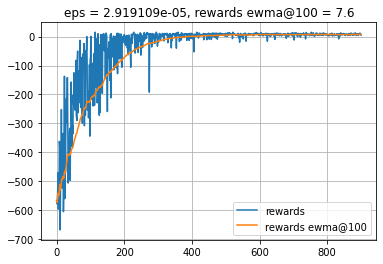

In [6]:
from IPython.display import clear_output


rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        plot_rewards(rewards, agent.epsilon)

## Binarized state spaces

Now that we know how to use our agent in case of discrete observation space, let's try to use agent to train efficiently on `CartPole-v0`. This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x, ndigits)` to round real number to a given amount of digits.

The tricky part is to get the `ndigits` right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

first state:[0.01591345 0.00998037 0.04140117 0.04158393]


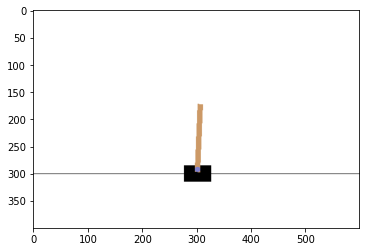

In [7]:
def make_env():
    return gym.make("CartPole-v0").env  # .env unwraps the TimeLimit wrapper


env = make_env()
n_actions = env.action_space.n

print(f"first state:{env.reset()}")
plt.imshow(env.render("rgb_array"));

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [8]:
import numpy as np


def visualize_cartpole_observation_distribution(states):
    states = np.array(states)
    fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
    axes = axes.flatten()
    for i, title in enumerate(
        ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Velocity At Tip']
    ):
        ax = axes[i]
        ax.hist(states[:, i], bins=20)
        ax.set_title(title)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()

    fig.tight_layout()

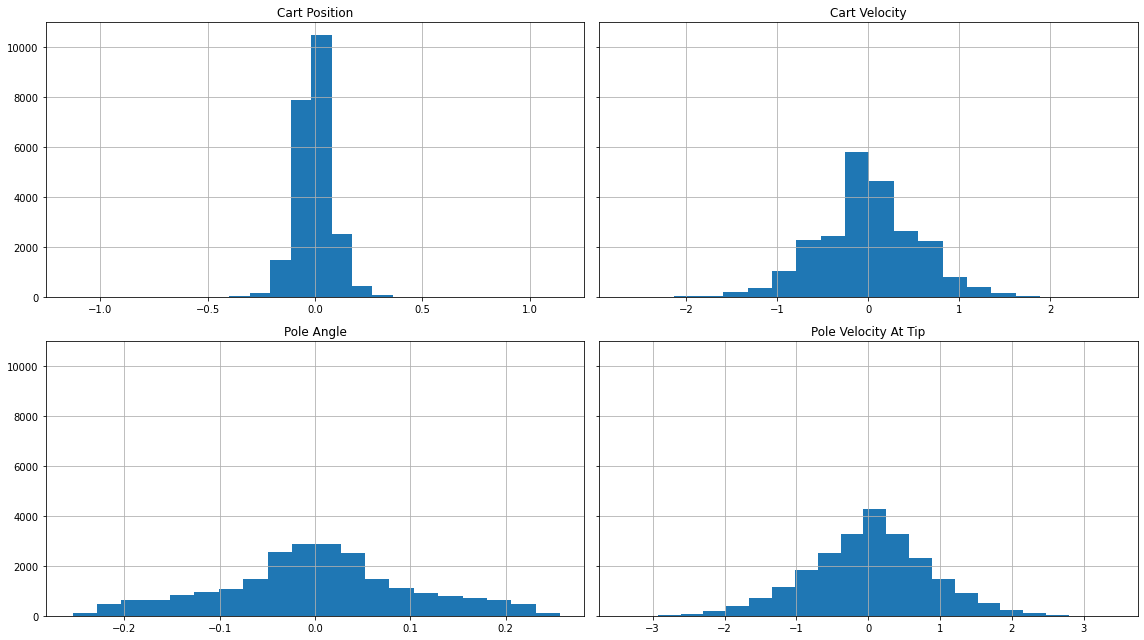

In [9]:
states = []
for _ in range(1000):
    states.append(env.reset())
    done = False
    while not done:
        state, _, done, _ = env.step(env.action_space.sample())
        states.append(state)

visualize_cartpole_observation_distribution(states)

### Binarize environment

In [10]:
from gym.core import ObservationWrapper


class Binarizer(ObservationWrapper):
    def observation(self, state):
        # YOUR CODE HERE
        # Binarize state, e.g. round it to some amount digits (hint: you can do that with round(x, ndigits))
        # You might need to pick a different n_digits for each dimension based on histograms.
        features_ndigits = [1, 1, 1, 1]
        for feature_index in range(len(state)):
            state[feature_index] = round(state[feature_index], features_ndigits[feature_index])

        return tuple(state)

In [11]:
env = Binarizer(make_env())

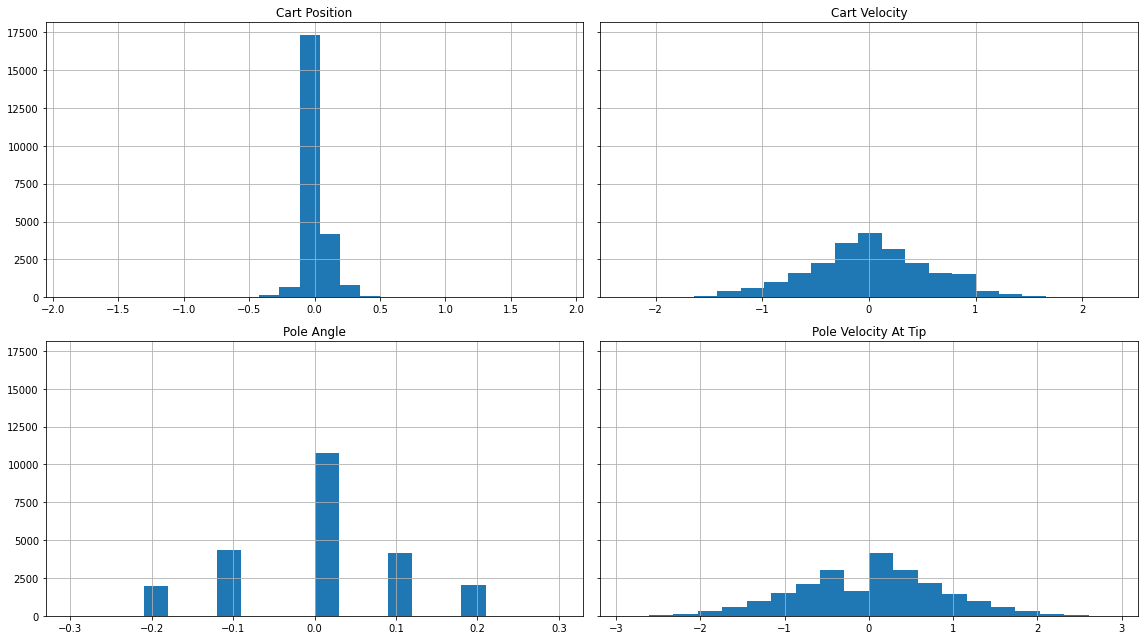

In [12]:
states = []
for _ in range(1000):
    states.append(env.reset())
    done = False
    while not done:
        state, _, done, _ = env.step(env.action_space.sample())
        states.append(state)

visualize_cartpole_observation_distribution(states)

### Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__ 
* Note that increasing the number of digits for one dimension of the observations increases your state space by a factor of $10$.
* If your binarization is too fine-grained, your agent will take much longer than 10000 steps to converge. You can either increase the number of iterations and reduce epsilon decay or change binarization. In practice we found that this kind of mistake is rather frequent.
* If your binarization is too coarse, your agent may fail to find the optimal policy. In practice we found that on this particular environment this kind of mistake is rare.
* **Start with a coarse binarization** and make it more fine-grained if that seems necessary.
* Having $10^3$–$10^4$ distinct states is recommended (len(agent._qvalues)), but not required.
* If things don't work without annealing $\varepsilon$, consider adding that, but make sure that it doesn't go to zero too quickly.

A reasonable agent should attain an average reward of at least 50.

In [13]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, gamma=0.99, n_actions=n_actions)

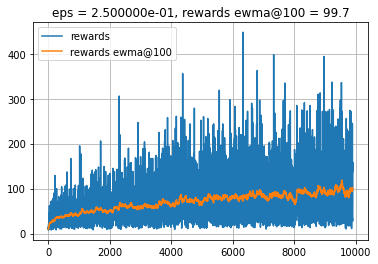

In [14]:
rewards = []
for i in range(10000):
    rewards.append(play_and_train(env, agent))
    # YOUR CODE HERE (optional)
    # Adjust epsilon.

    if i % 100 == 0:
        clear_output(True)
        plot_rewards(rewards, agent.epsilon)

In [15]:
print('Your agent has learned {} Q-values.'.format(len(agent._qvalues)))

Your agent has learned 12108 Q-values.
